In [32]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import math

import torch
from torchdiffeq import odeint

import main as m
import utils as u
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
ts = torch.tensor([0.0,1.0,2,3,4,5,8,10,15,20,30,40,60,70,80])
n_vars = 1
batch_size = 1000
d_model = 30
noise_std_ratio = 0.2


/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


tensor([[0.0490]], device='cuda:0')

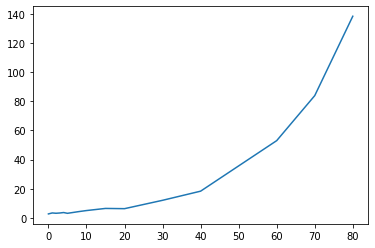

In [58]:
theta, sample = m.solve_ode_sample(batch_size, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts, device='cuda')
plt.plot(ts, sample[0].to('cpu').reshape(len(ts), n_vars))
theta

In [46]:
%%time
inference_network = m.SeqGaussMixPosteriorV2(num_mixtures=2, d_model=d_model, 
                                             num_obs_vars=n_vars,
                                             num_trans_layers=1).cuda()
optimizer = torch.optim.Adam(params=inference_network.parameters())

gen_traces_fn = lambda: m.solve_ode_sample(batch_size, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                          device='cuda')

losses = m.amortize_inference(inference_network, gen_traces_fn, optimizer, 3000)

/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


CPU times: user 1min 58s, sys: 889 ms, total: 1min 59s
Wall time: 1min 59s


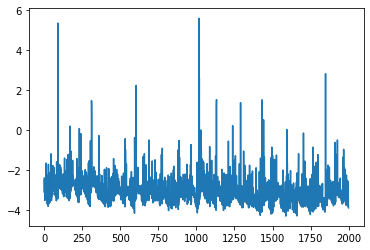

In [51]:
plt.plot(losses)

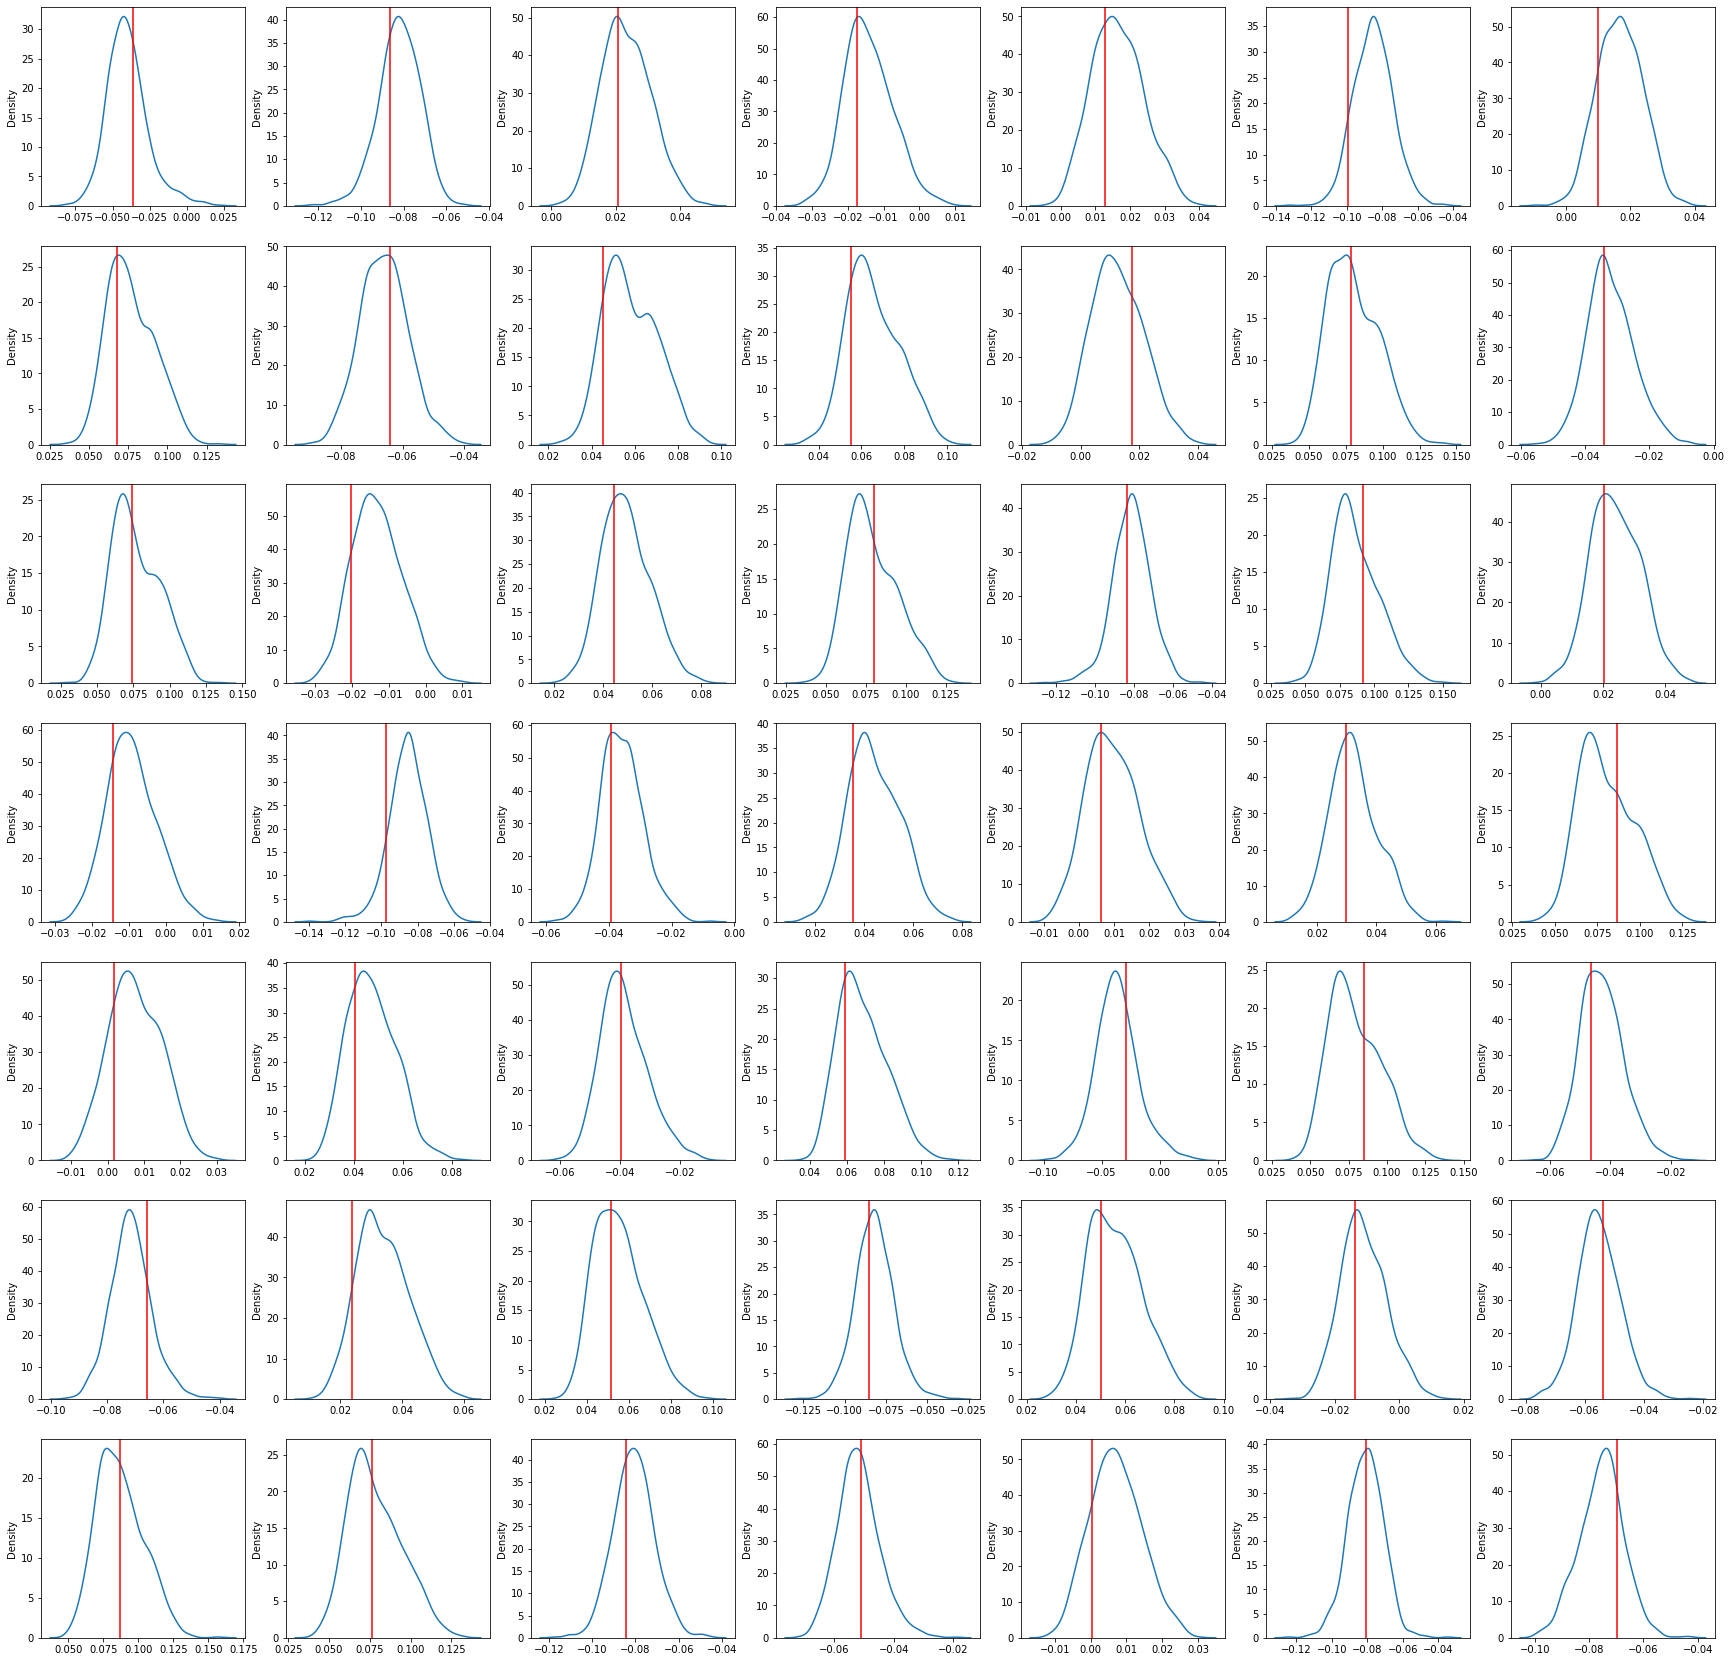

In [84]:
num_plots = 49
num_cols = 7
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30))
for i in range(num_plots):
    theta, sample = m.solve_ode_sample(1, n_vars, [-10.0, 10.0], [-0.1, 0.1], noise_std_ratio, ts,
                                       device='cuda')
    c = i % num_cols
    r = math.floor(i/num_cols)
    dist = inference_network.get_q_x_given_obs(sample[0:1])
    sns.kdeplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
                                   means=dist.normals.loc[0], 
                                   stds=dist.normals.scale[0]).sample(1000).to('cpu'),
                ax=axes[r,c])
    axes[r,c].axvline(theta[0].to('cpu').item(), color='red')
    
    
# idx = 0
# dist = inference_network.get_q_x_given_obs(sample[idx:idx+1])
# sns.distplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
#                 means=dist.normals.loc[0], 
#                 stds=dist.normals.scale[0]).sample(1000).to('cpu'))
# plt.axvline(theta[0].to('cpu'), color='red')

# print(dist.mixture_probs)
# print(dist.normals.loc)
# print(dist.normals.scale)
# print(theta[idx])